# Trophic position, in the Arctic Ocean. To create the maps that I want, I think I need to find this remmapped. So I will attempt to do this! 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
#import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from cartopy.util import add_cyclic_point

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## Import the trophic level information quarterly, so that we can create the figure that we wish! 

In [6]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

## Import the TL for every season

In [7]:
TL_fall = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_fall.nc')
TL_winter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_winter.nc')
TL_summer = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_summer.nc')
TL_spring=xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_spring.nc')

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_fall.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_fall.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset year
			found dataset z_t_150m
			found dataset nlat
			found dataset nlon
			found dataset zoo1TL_fall
			found dataset zoo2TL_fall
			found dataset zoo3TL_fall
			found dataset zoo4TL_fall
			found dataset zoo5TL_fall
			found dataset zoo6TL_fall
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0xd0000 ext_ncid 0xd0000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/zooTL_62yr_fall.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 10 natts: 0
		 DIMENSION - dimid: 0 name: year len: 62 unlimited: 0
		 DIMENSION - dimid: 1 name: z_t_150m len: 15 unlimited: 0
		 DIMENSION

In [9]:
%%time
TL_fall['zooTL_fall'] = xr.concat([TL_fall[v+'TL_fall'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 10.3 ms


In [10]:
%%time
TL_summer['zooTL_summer'] = xr.concat([TL_summer[v+'TL_summer'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')
TL_spring['zooTL_spring'] = xr.concat([TL_spring[v+'TL_spring'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')
TL_winter['zooTL_winter'] = xr.concat([TL_winter[v+'TL_winter'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 28.8 ms


In [11]:
TL_fall

<xarray.Dataset>
Dimensions:      (year: 62, z_t_150m: 15, nlat: 384, nlon: 320)
Coordinates:
  * year         (year) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61
  * z_t_150m     (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * nlat         (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon         (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
Data variables:
    zoo1TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zoo2TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zoo3TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zoo4TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zoo5TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zoo6TL_fall  (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>
    zooTL_fall   (year, z_t_150m, nlat, nlon) float64 dask.array<chunksize=(62, 15, 384, 320), meta=np.ndarray>

		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
			NC4_get_vars: var->hdr.name zoo1TL_winter mem_nc_type 6
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4

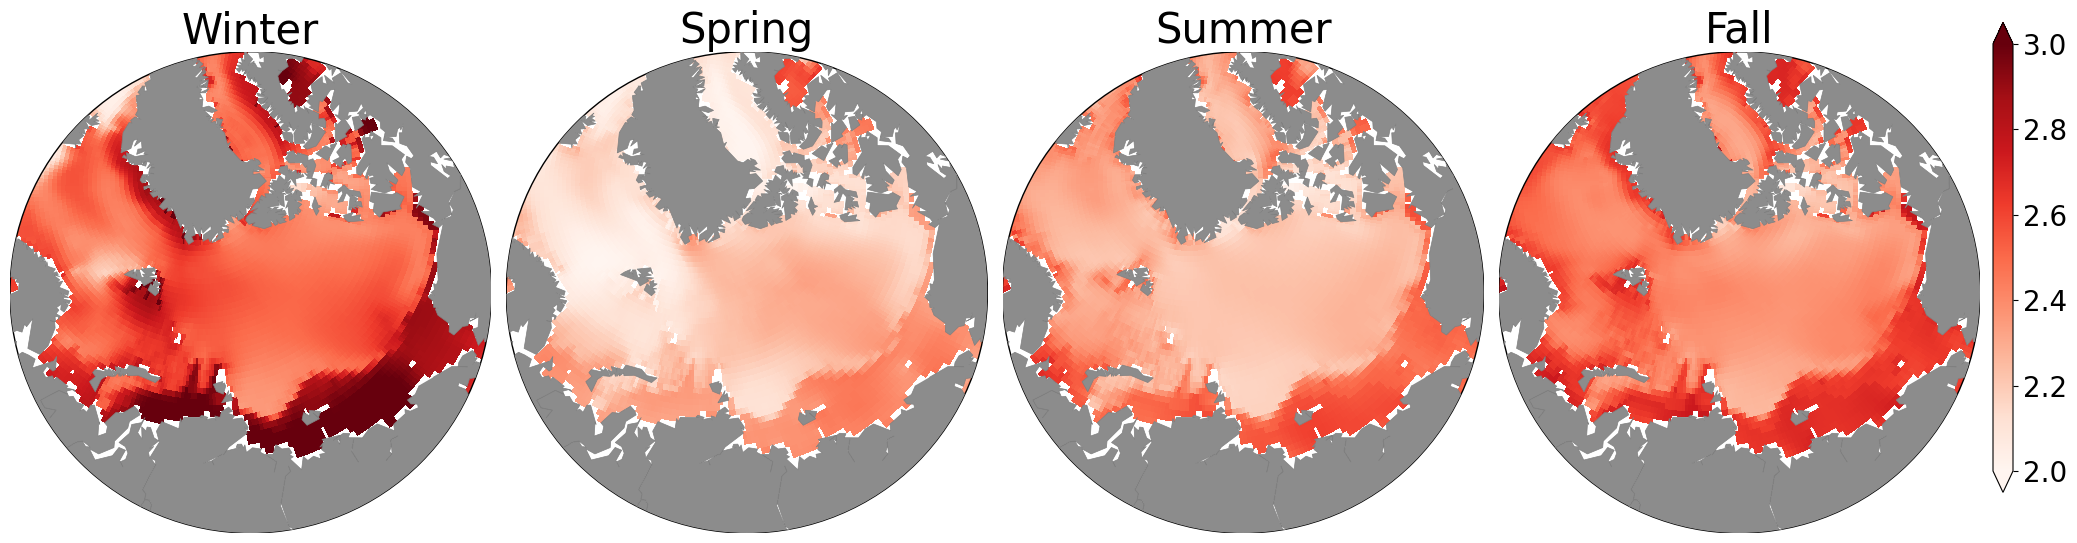

In [12]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(20, 10))
## WINTER 
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_winter.zooTL_winter[:,:,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,winter,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter', fontsize =30)

## SPRING
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_spring.zooTL_spring[:,:,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,spring,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Spring', fontsize =30)

## SUMMER
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_summer.zooTL_summer[:,:,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,summer,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer', fontsize =30)


##FALL
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_fall.zooTL_fall[:,:,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,fall,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Fall', fontsize =30);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.47])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()
#fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/TL_seasonal_AO_20year_clim.png', dpi=600, bbox_inches='tight')

## Import High vs Low temp, ice and NO3

In [13]:
%%time
temp_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc');

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset TEMP
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x110000 ext_ncid 0x110000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlim

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 601 ms


		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
			NC4_get_vars: var->hdr.name time mem_nc_type 10
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_var_all: ncid 0x110000 varid 0
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_att: ncid 0x110000 varid 0 name scale_factor
			nc4_get_att: ncid 0x110000 varid 0 name scale_factor attnum -1 mem_type 0
		NC4_inq_att: ncid 0x110000 varid 0 name add_offset
			nc4_get_att: ncid 0x110000 varid 0 name add_offset attnum -1 mem_type 0
		NC4_inq_var_all: ncid 0x110000 varid 1
		NC4_inq_var_all: ncid 0x110000 varid 1
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: n

In [14]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
			NC4_get_vars: var->hdr.name TEMP mem_nc_type 6
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x1100

In [15]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 2.34 s, sys: 128 ms, total: 2.47 s
Wall time: 3.93 s


In [16]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 12.9 s, sys: 130 ms, total: 13.1 s
Wall time: 25.3 s


In [17]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 833 ms, sys: 0 ns, total: 833 ms
Wall time: 1.55 s


In [18]:
zooTL_summer = np.array(TL_summer.zooTL_summer)
zooTL_spring = np.array(TL_spring.zooTL_spring)
zooTL_witner = np.array(TL_winter.zooTL_winter)
zooTL_fall = np.array(TL_fall.zooTL_fall)

		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_dim: ncid 0xf0000 dimid 0
		NC4_inq_dim: ncid 0xf0000 dimid 1
		NC4_inq_dim: ncid 0xf0000 dimid 2
		NC4_inq_dim: ncid 0xf0000 dimid 3
		NC4_inq_dim: ncid 0xf0000 dimid 0
		NC4_inq_dim: ncid 0xf0000 dimid 1
		NC4_inq_dim: ncid 0xf0000 dimid 2
		NC4_inq_dim: ncid 0xf0000 dimid 3
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_dim: ncid 0xf0000 dimid 0
		NC4_inq_dim: ncid 0xf0000 dimid 1
		NC4_inq_dim: ncid 0xf0000 dimid 2
		NC4_inq_dim: ncid 0xf0000 dimid 3
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_dim: ncid 0xf0000 dimid 0
		NC4_inq_dim: ncid 0xf0000 dimid 1
		NC4_inq_dim: ncid 0xf0000 dimid 2
		NC4_inq_dim: ncid 0xf0000 dimid 3
		NC4_inq_var_all: ncid 0xf0000 varid 4
			NC4_get_vars: var->hdr.name zoo1TL_summer mem_nc_type 6
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4_inq_var_all: ncid 0xf0000 varid 4
		NC4

In [19]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_temp_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(zooTL_witner[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_temp_years_winter[latitude,longitude]= np.nanmean(zooTL_fall[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(zooTL_fall[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

In [20]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 4.46 ms, sys: 21.1 ms, total: 25.5 ms
Wall time: 236 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset ECOSYS_IFRAC
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x120000 ext_ncid 0x120000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - di

In [21]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
			NC4_get_vars: var->hdr.name ECOSYS_IFRAC mem_nc_type 6
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: nci

In [22]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 2.3 s, sys: 150 ms, total: 2.45 s
Wall time: 2.53 s


In [23]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [24]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [25]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_ice_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_ice_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

CPU times: user 32.1 s, sys: 213 ms, total: 32.3 s
Wall time: 46.7 s


In [26]:
%%time
NO3_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc');

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 138 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset NO3
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x130000 ext_ncid 0x130000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlimited

In [27]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x13000

CPU times: user 735 ms, sys: 1.19 s, total: 1.92 s
Wall time: 3.38 s


In [28]:
NO3_ds = np.array(NO3_ds_inter.NO3)

		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x13000

In [29]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 2.28 s, sys: 143 ms, total: 2.42 s
Wall time: 2.45 s


In [30]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 12.6 s, sys: 770 ms, total: 13.4 s
Wall time: 13.9 s


In [31]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [32]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))
        high_no3_years_summer[latitude,longitude] = np.nanmean(zooTL_summer[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(zooTL_spring[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(zooTL_spring[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(zooTL_fall[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2))

        low_no3_years_winter[latitude,longitude]= np.nanmean(zooTL_witner[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(zooTL_witner[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1,2)) 
 

CPU times: user 34.1 s, sys: 5.4 s, total: 39.5 s
Wall time: 1min 15s


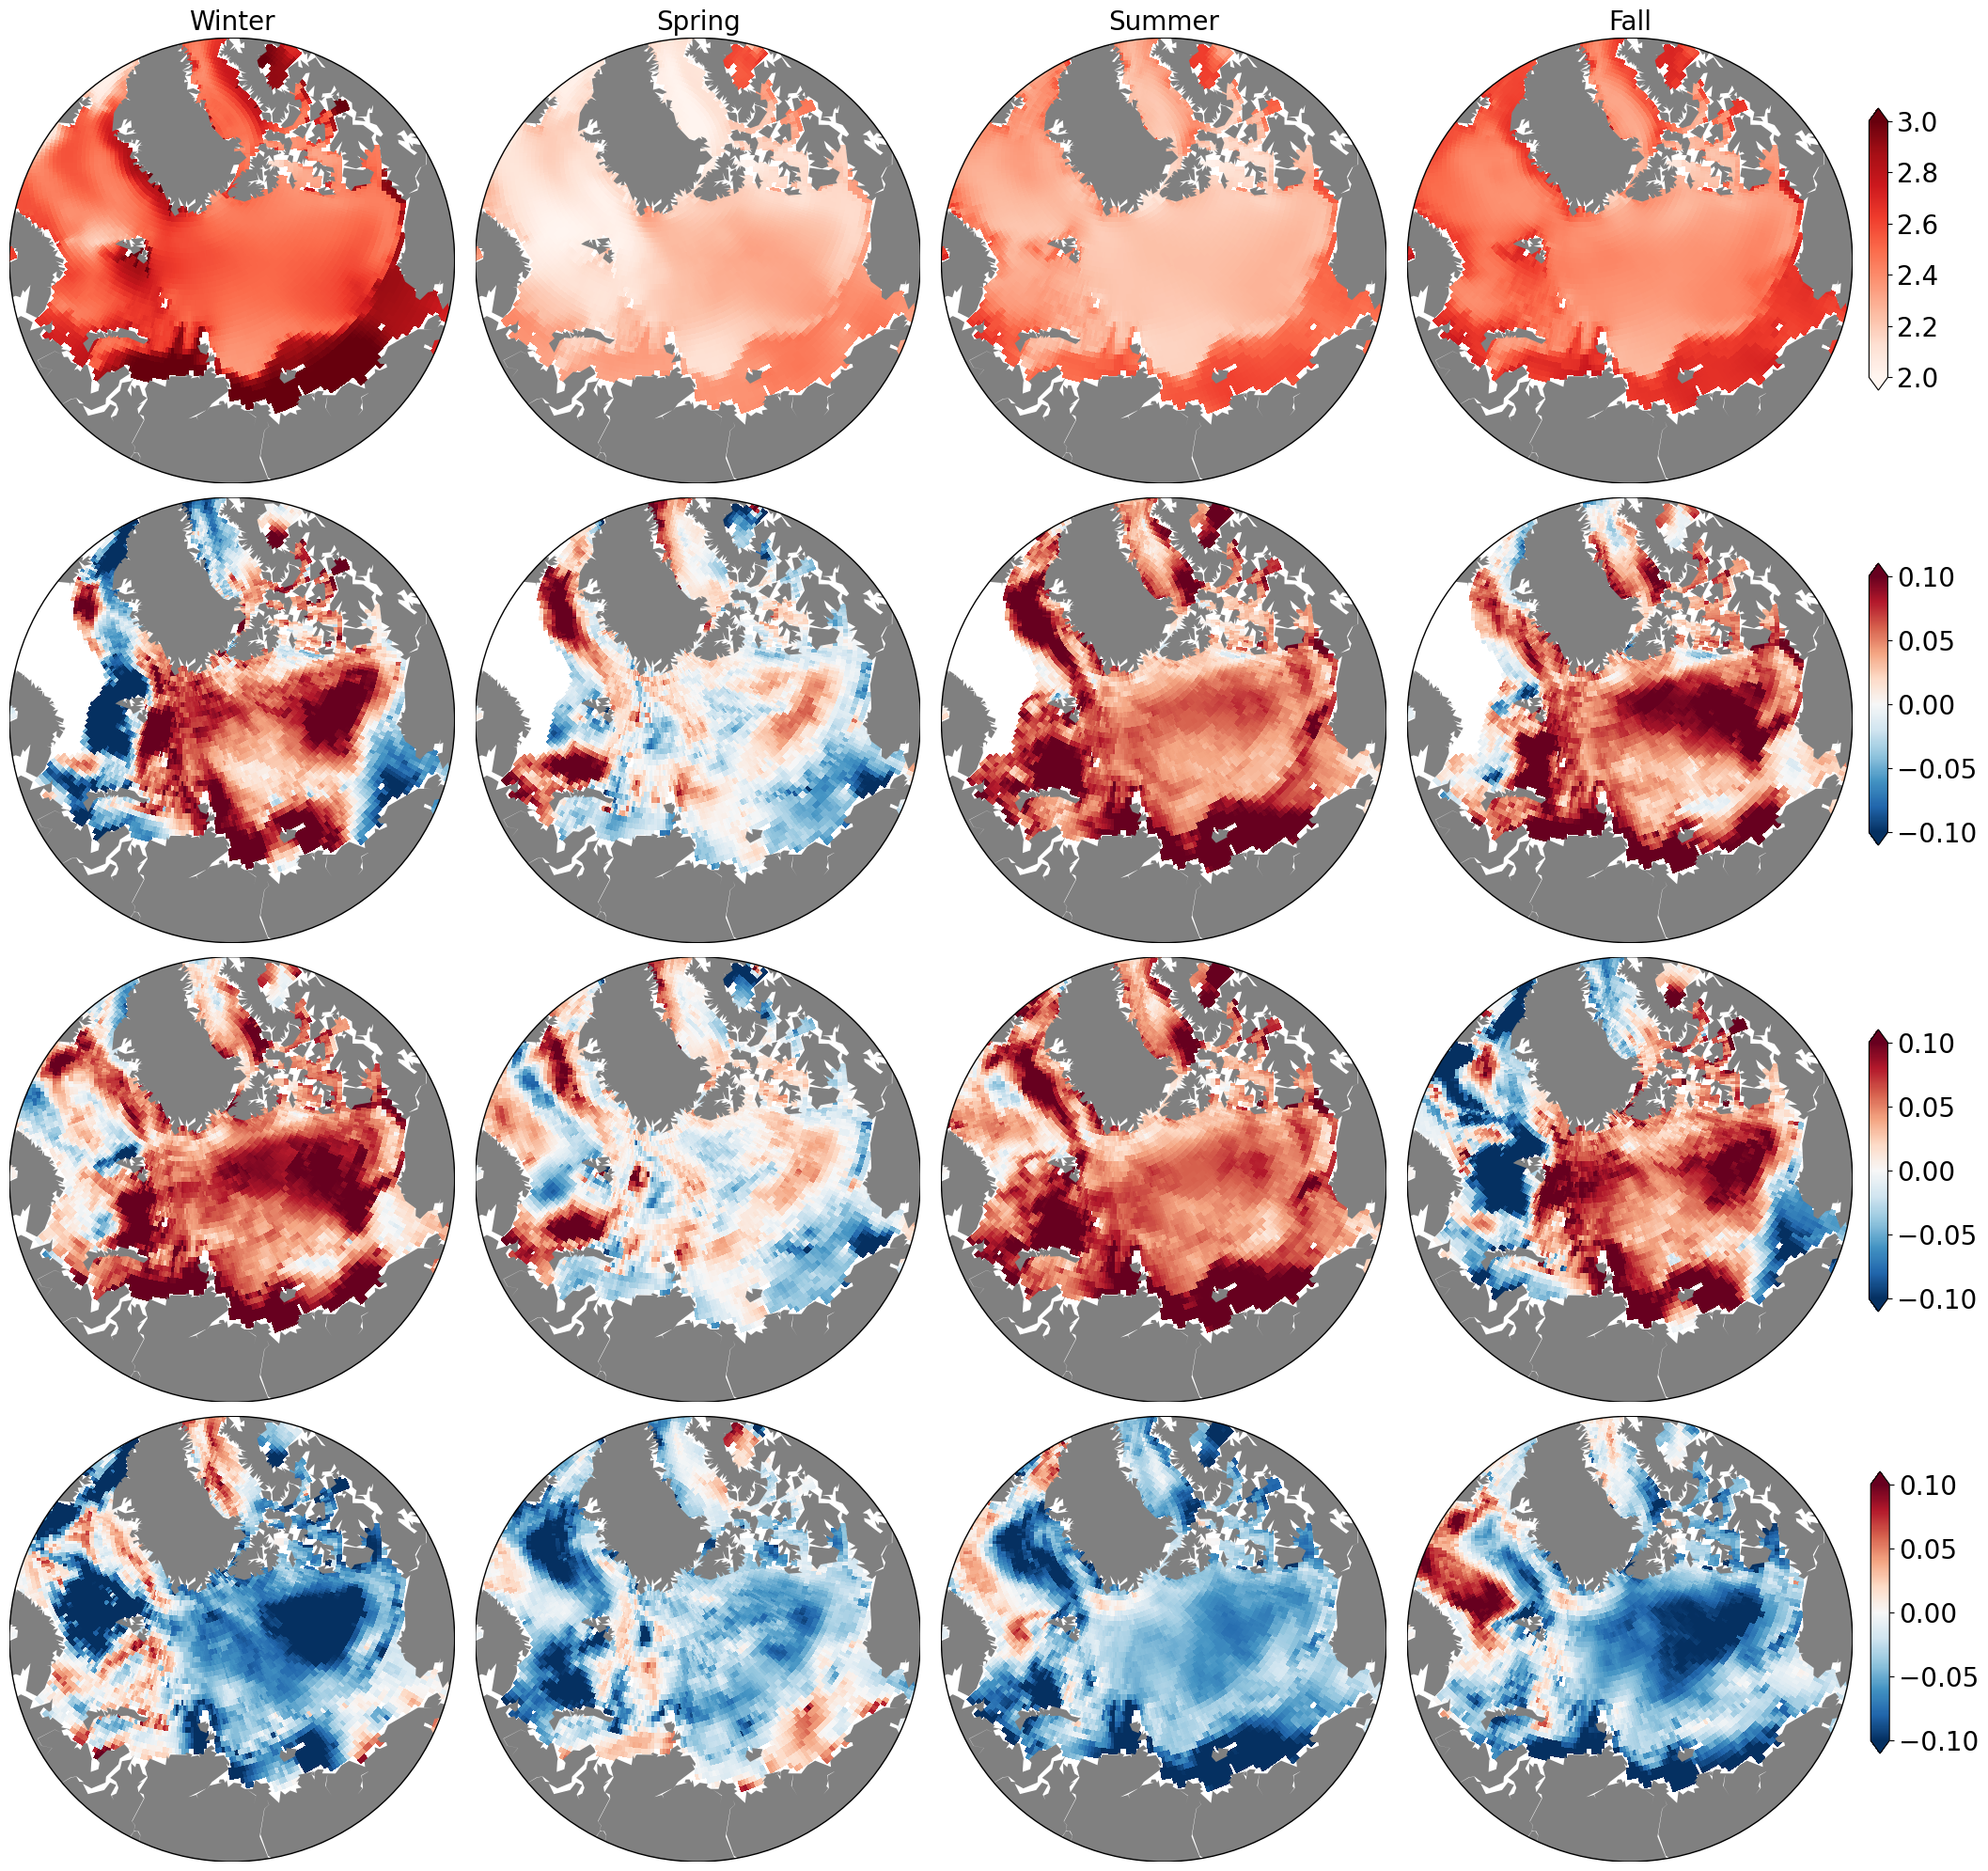

In [34]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 10, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
fig = plt.figure(figsize=(20, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooTL_witner,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Reds', vmin = 2, vmax = 3);
ax.set_title('Winter', fontsize=20)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooTL_spring,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring,cmap='Reds', vmin = 2, vmax = 3);
ax.set_title('Spring', fontsize=20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooTL_summer,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer,cmap='Reds', vmin = 2, vmax = 3);
ax.set_title('Summer', fontsize=20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooTL_fall,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall,cmap='Reds', vmin = 2, vmax = 3);
cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
ax.set_title('Fall', fontsize=20)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn =-.1
vmaxx=.1
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/quarterly_TL_interannual.png',dpi=200, bbox_inches='tight')